In [1]:
import uuid, sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import math
import random
import matplotlib.pyplot as plt
from tqdm import trange

from sklearn import metrics
from scipy import stats
from collections import Counter

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
print(torch.cuda.get_device_name(0))

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW
import training_utils.partitioning_utils as pat_utils

torch.manual_seed(0)

from accelerate import Accelerator
torch.cuda.empty_cache()

NVIDIA A100-PCIE-40GB


In [2]:
### Setting a seed to have the same initiation of weights

def set_seed(seed: int = 42):
    # Python & NumPy
    random.seed(seed)
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU

    # CuDNN settings (for convolution etc.)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # (Optional) for some Python hashing randomness
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 0
set_seed(SEED)

In [3]:
import wandb
wandb.login()

/work3/s232958/envs/esm_gpu/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/work3/s232958/envs/esm_gpu/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annot

True

In [4]:
os.chdir("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts")
# print(os.getcwd())

print("PyTorch:", torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

PyTorch: 2.5.1
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [5]:
# Model parameters
memory_verbose = False
use_wandb = True # Used to track loss in real-time without printing

seq_embed_dimension = 1280 #| 960 | 1152
struct_embed_dimension = 256
number_of_recycles = 2
padding_value = -5000

In [6]:
## Output path
trained_model_dir = "/work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116"

## Embeddings paths
binders_embeddings = "/work3/s232958/data/PPint_DB/binders_embeddings_esm2"
targets_embeddings = "/work3/s232958/data/PPint_DB/targets_embeddings_esm2"

## Contact maps paths
binders_contacts = "/work3/s232958/data/PPint_DB/binders_contacts"
targets_contacts = "/work3/s232958/data/PPint_DB/targets_contacts"

# ## Training variables
runID = uuid.uuid4()

def print_mem_consumption():
    # 1. Total memory available on the GPU (device 0)
    t = torch.cuda.get_device_properties(0).total_memory
    # 2. How much memory PyTorch has *reserved* from CUDA
    r = torch.cuda.memory_reserved(0)
    # 3. How much of that reserved memory is actually *used* by tensors
    a = torch.cuda.memory_allocated(0)
    # 4. Reserved but not currently allocated (so “free inside PyTorch’s pool”)
    f = r - a

    print("Total memory: ", t/1e9)      # total VRAM in GB
    print("Reserved memory: ", r/1e9)   # PyTorch’s reserved pool in GB
    print("Allocated memory: ", a//1e9) # actually in use (integer division)
    print("Free memory: ", f/1e9)       # slack in the reserved pool in GB
print_mem_consumption()

Total memory:  42.405855232
Reserved memory:  0.0
Allocated memory:  0.0
Free memory:  0.0


### Loading PPint dataframe

In [7]:
path_to_mmseqs_clustering = "/work3/s232958/data/PPint_DB/3_å_dataset5_singlefasta/clusterRes40"
all_seqs, clust, clust_keys = pat_utils.mmseqs_parser(path_to_mmseqs_clustering)

path_to_interaction_df = "/work3/s232958/data/PPint_DB/disordered_interfaces_no_cutoff_filtered_nonredundant80_3å_5.csv.gz"
disordered_interfaces_df = pd.read_csv(path_to_interaction_df,index_col=0).reset_index(drop=True)
disordered_interfaces_df["PDB_chain_name"] = (disordered_interfaces_df["PDB"] + "_" + disordered_interfaces_df["chainname"]).tolist()
disordered_interfaces_df["index_num"] = np.arange(len(disordered_interfaces_df))
disordered_interfaces_df["chain_name_index"] = [row["PDB_chain_name"] + "_" + str(row["index_num"]) for index, row in disordered_interfaces_df.iterrows()]
disordered_interfaces_df = disordered_interfaces_df.set_index("PDB_interface_name")
disordered_interfaces_df["interface_residues"] = disordered_interfaces_df["interface_residues"].apply(lambda x: ast.literal_eval(x))
# disordered_interfaces_df["inter_chain_hamming"] = [1 - (Ldistance(seq.split("-")[0], seq.split("-")[1]))/np.max([len(seq.split("-")[0]), len(seq.split("-")[1])]) for seq in disordered_interfaces_df["protien_interface_sequences"]]
disordered_interfaces_df["dimer"] = disordered_interfaces_df["inter_chain_hamming"] > 0.60
disordered_interfaces_df["clust_keys"] = [clust_keys.get(row["chain_name_index"]) for index, row in disordered_interfaces_df.iterrows()] 

pdb_interface_and_clust_keys = {index:disordered_interfaces_df.loc[index,"clust_keys"].values.tolist() for index in tqdm(disordered_interfaces_df.index.drop_duplicates(), total=len(disordered_interfaces_df)/2)}
new_clusters, new_clusters_clustkeys = pat_utils.recluster_mmseqs_keys_to_non_overlapping_groups(pdb_interface_and_clust_keys)

### Creating train and test datasets based on train and test-idexes
train_indexes, test_indexes = pat_utils.run_train_test_partition(interaction_df=disordered_interfaces_df,
                                                    clustering=new_clusters, # Clusters from Bidentate-graphs
                                                    train_ratio=0.8, 
                                                    test_ratio=0.2, 
                                                    v=True, 
                                                    seed=0)

disordered_interfaces_df["ID"] = [row["PDB"]+"_"+str(row["interface_index"])+"_"+row["chainname"] for __, row in disordered_interfaces_df.iterrows()]
disordered_interfaces_df["PDB_interface_name"] = disordered_interfaces_df.index

100%|██████████████████████████████████████████████████████████████████████████| 24725/24725.0 [00:36<00:00, 684.77it/s]
100%|█████████████████████████████████████████████████████████████████████████| 27834/27834 [00:00<00:00, 679448.83it/s]


0.8
0.2


In [8]:
grouped = {}
for _, row in disordered_interfaces_df.iterrows():
    iface = row["PDB_interface_name"]
    seq = row["sequence"]
    rid = row["ID"]
    dimer = row["dimer"]
    
    if iface not in grouped:
        grouped[iface] = {
            "sequences": [],
            "IDs": [],
            "dimer": dimer,        # keep the dimer value for this interface
        }
    else:
        # Optional: sanity-check it's consistent per interface
        if grouped[iface]["dimer"] != dimer:
            print(f"Warning: multiple dimers for interface {iface}:",
                  grouped[iface]['dimer'], "vs", dimer)

    grouped[iface]["sequences"].append(seq)
    grouped[iface]["IDs"].append(rid)

records = []
for iface, vals in grouped.items():
    seqs = vals["sequences"]
    ids = vals["IDs"]
    if len(seqs) >= 2 and len(ids) >= 2:
        records.append({
            "interface_id": iface,
            "seq1": seqs[0],
            "seq2": seqs[1],
            "ID1": ids[0],
            "ID2": ids[1],
            "dimer": vals["dimer"],   # <- add dimer to final record
        })

PPint_interactions_NEW = pd.DataFrame(records)
PPint_interactions_NEW["seq_target_len"] = [len(row.seq1) for __, row in PPint_interactions_NEW.iterrows()]
PPint_interactions_NEW["seq_binder_len"] = [len(row.seq2) for __, row in PPint_interactions_NEW.iterrows()]
PPint_interactions_NEW["target_binder_id"] = PPint_interactions_NEW["ID1"] + "_" + PPint_interactions_NEW["ID2"]

PPint_interactions_NEW.head()

,interface_id,seq1,seq2,ID1,ID2,dimer,seq_target_len,seq_binder_len,target_binder_id
0,6NZA_0,MNTVRSEKDSMGAIDVPADKLWGAQTQRSLEHFRISTEKMPTSLIH...,TVRSEKDSMGAIDVPADKLWGAQTQRSLEHFRISTEKMPTSLIHAL...,6NZA_0_A,6NZA_0_B,True,461,459,6NZA_0_A_6NZA_0_B
1,9JKA_1,VAAGATLALLSFLTPLAFLLLPPLLWREELEPCGTACEGLFISVAF...,VAAGATLALLSFLTPLAFLLLPPLLWREELEPCGTACEGLFISVAF...,9JKA_1_B,9JKA_1_C,True,362,362,9JKA_1_B_9JKA_1_C
2,8DQ6_1,PTLNLFTNIPVDAVTCSDILKDATKAVAKIIGKPESYVMILLNSGV...,PTLNLFTNIPVDAVTCSDILKDATKAVAKIIGKPESYVMILLNSGV...,8DQ6_1_B,8DQ6_1_C,True,109,97,8DQ6_1_B_8DQ6_1_C
3,2YMZ_0,ARMFEMFNLDWKSGGTMKIKGHISEDAESFAINLGCKSSDLALHFN...,ARMFEMFNLDWKSGGTMKIKGHISEDAESFAINLGCKSSDLALHFN...,2YMZ_0_A,2YMZ_0_B,True,130,130,2YMZ_0_A_2YMZ_0_B
4,6IDB_0,DKICLGHHAVSNGTKVNTLTERGVEVVNATETVERTNIPRICSKGK...,GLFGAIAGFIENGWEGLIDGWYGFRHQNAQGEGTAADYKSTQSAID...,6IDB_0_A,6IDB_0_B,False,317,172,6IDB_0_A_6IDB_0_B


In [9]:
# sample random 10%
train_indexes_sample = random.sample(train_indexes, int(len(train_indexes) * 0.1))
test_indexes_sample = random.sample(test_indexes, int(len(test_indexes) * 0.1))

In [10]:
Df_train = PPint_interactions_NEW[PPint_interactions_NEW.interface_id.isin(train_indexes_sample)]
Df_test = PPint_interactions_NEW[PPint_interactions_NEW.interface_id.isin(test_indexes_sample)]
Df_train

,interface_id,seq1,seq2,ID1,ID2,dimer,seq_target_len,seq_binder_len,target_binder_id
24,6GRH_2,MINILPFEIISRNTKTLLITYISSVDITHEGMKKVLESLRSKQGII...,MINVYSNLMSAWPATMAMSPKLNRNMPTFSQIWDYERITPASAAGE...,6GRH_2_2,6GRH_2_D,False,284,396,6GRH_2_2_6GRH_2_D
34,8R57_0,MIISKKNRNEICKYLFQEGVLYAKKDYNLAKHPQIDVPNLQVIKLM...,TQISKKKKFVSDGVFYAELNEMLTRELAEDGYSGVEVRVTPMRTEI...,8R57_0_K,8R57_0_F,False,83,211,8R57_0_K_8R57_0_F
47,7CUJ_2,SVLDIGLPMSALQRKMMHRLVQYFAFCIDHFCTGPSDSRIQEKIRL...,IELEYKRKPIPDYDFMKGLETTLQELYVEHQSKKRR,7CUJ_2_B,7CUJ_2_D,False,256,36,7CUJ_2_B_7CUJ_2_D
53,1UZR_0,RVSAINWNRLQDEKDAEVWDRLTGNFWLPEKVPVSNDIPSWGTLTA...,DRVSAINWNRLQDEKDAEVWDRLTGNFWLPEKVPVSNDIPSWGTLT...,1UZR_0_A,1UZR_0_C,True,282,283,1UZR_0_A_1UZR_0_C
55,2B5I_0,STKKTQLQLEHLLLDLQMILNGINNYKNPKLTRMLTFKFYMPKKAT...,SQFTCFYNSRAQISCVWSQTSCQVHAWPDRRRWQQTCELLPVSQAS...,2B5I_0_A,2B5I_0_B,False,120,196,2B5I_0_A_2B5I_0_B
...,...,...,...,...,...,...,...,...,...
24648,3X2Z_1,GMKVTFLGHAVVLIEGKKNIIIDPFISGNPVCPVKLEGLPKIDYIL...,GMKVTFLGHAVVLIEGKKNIIIDPFISGNPVCPVKLEGLPKIDYIL...,3X2Z_1_B,3X2Z_1_C,True,227,227,3X2Z_1_B_3X2Z_1_C
24668,2RCZ_0,GSKVTLVKSRKNEEYGLRLASHIFVKEISQDSLAARDGNIQEGDVV...,GSKVTLVKSRKNEEYGLRLASHIFVKEISQDSLAARDGNIQEGDVV...,2RCZ_0_A,2RCZ_0_B,True,79,81,2RCZ_0_A_2RCZ_0_B
24669,3HNP_3,TLTMGFIGFGKSANRYHLPYLKTRNNIKVKTIFVRQINEELAAPYE...,TLTMGFIGFGANRYHLPYLKTRNNIKVKTIFVRQINEELAAPYEER...,3HNP_3_D,3HNP_3_F,True,344,294,3HNP_3_D_3HNP_3_F
24696,6OVP_0,MSLKVDGFTSSIIFDVIRDGLNDPSQAKQKAESIKKANAIIVFNLK...,MSLKVDGFTSSIIFDVIRDGLNDPSQAKQKAESIKKANAIIVFNLK...,6OVP_0_A,6OVP_0_B,True,118,128,6OVP_0_A_6OVP_0_B


In [11]:
Df_test

,interface_id,seq1,seq2,ID1,ID2,dimer,seq_target_len,seq_binder_len,target_binder_id
7,4POB_0,DHATVTVTDDSFQEDVVSSNKPVLVDFWATWCGPCKMVAPVLEEIA...,ATVTVTDDSFQEDVVSSNKPVLVDFWATWCGPCKMVAPVLEEIAKD...,4POB_0_A,4POB_0_B,True,107,105,4POB_0_A_4POB_0_B
12,7T6C_0,YYPFVRKALFQLDPERAHEFTFQQLRRITGTPFEALVRQKVPAKPV...,YYPFVRKALFQLDPERAHEFTFQQLRRITGTPFEALVRQKVPAKPV...,7T6C_0_A,7T6C_0_B,True,335,335,7T6C_0_A_7T6C_0_B
28,1EGP_0,LKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTL,YNRVRVFYNPGTNVVNHVPHVG,1EGP_0_A,1EGP_0_B,False,39,22,1EGP_0_A_1EGP_0_B
62,7YH3_0,KVENPLLISLYSHYVEQILSETNSIDDANQKLRDLGKELGQQIYLN...,KVENPLLISLYSHYVEQILSETNSIDDANQKLRDLGKELGQQIYLN...,7YH3_0_A,7YH3_0_C,True,150,155,7YH3_0_A_7YH3_0_C
70,4WMO_1,GYRSCNEIKSSDSRAPDGIYTLATEDGESYQTFCDTTNGGGWTLVA...,GYRSCNEIKSSDSRAPDGIYTLATEDGESYQTFCDTTNGGGWTLVA...,4WMO_1_D,4WMO_1_E,True,271,271,4WMO_1_D_4WMO_1_E
...,...,...,...,...,...,...,...,...,...
24455,2OYS_0,NKIFIYAGVRNHNSKTLEYTKRLSSIISSRNNVDISFRTPFNSELE...,NKIFIYAGVRNHNSKTLEYTKRLSSIISSRNNVDISFRTPFNSELE...,2OYS_0_A,2OYS_0_B,True,227,227,2OYS_0_A_2OYS_0_B
24491,6XRF_1,TLYRLHEADLEIPDAWQDQSINIFKLPASGPAREASFVISRDASQG...,MDAQAAARLGDEIAHGFGVAAMVAGAVAGALIGAAVVAAATGGLAA...,6XRF_1_B,6XRF_1_C,False,140,57,6XRF_1_B_6XRF_1_C
24507,5Z2L_0,GAFTGKTVLILGGSRGIGAAIVRRFVTDGANVRFTYAGSKDAAKRL...,GAFTGKTVLILGGSRGIGAAIVRRFVTDGANVRFTYAGSKDAAKRL...,5Z2L_0_A,5Z2L_0_B,True,239,243,5Z2L_0_A_5Z2L_0_B
24617,4LRS_0,APRVRITDSTLRDGSHAMAHQFTEEQVRATVHALDAAGVEVIEVSH...,GKAVAAIVGPGNIGTDLLIKLQRSEHIEVRYMVGVDPASEGLARAR...,4LRS_0_A,4LRS_0_B,False,337,294,4LRS_0_A_4LRS_0_B


#### I will use `len(Df_train)` of datapoints for training, `len(Df_test)` for testing and `ALL` metaanalysis datapoints for validation.

### ESM2 encoding sequences and extractinf contact maps

In [12]:
# ### Loading ESM2
# model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")
# model.eval().to("cuda")
# batch_converter = alphabet.get_batch_converter()

#### Sequences embeddings

In [13]:
# path_to_output_embeddings_targets = "/work3/s232958/data/PPint_DB/targets_embeddings_esm2"
# path_to_output_embeddings_binders = "/work3/s232958/data/PPint_DB/binders_embeddings_esm2"

# os.makedirs(path_to_output_embeddings_targets, exist_ok=True)
# os.makedirs(path_to_output_embeddings_binders, exist_ok=True)

# # helper: convert torch tensor to numpy
# def to_numpy(x):
#     try:
#         return x.detach().cpu().numpy()
#     except AttributeError:
#         return np.asarray(x)

# seen_targets = set()
# seen_binders = set()

#         ##### Trainign set #####

# for i in trange(len(Df_train), desc="Embedding"):
#     # ---- target ----
#     seq_target = Df_train.iloc[i]["seq1"]
#     target_id  = Df_train.iloc[i]["ID1"]

#     if target_id not in seen_targets:
#         data = [(target_id, seq_target)]
#         batch_labels, batch_strs, batch_tokens = batch_converter(data)
#         batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

#         with torch.no_grad():
#             L = model.num_layers
#             reps = model(
#                 batch_tokens.to("cuda"),
#                 repr_layers=[L],
#                 return_contacts=False
#             )["representations"][L]  # shape: [1, seq_len, hidden_dim]

#         emb_np = to_numpy(reps[0, :batch_lens[0]])  # trim padding for cleanliness

#         out_path = os.path.join(
#             path_to_output_embeddings_targets,
#             f"{target_id}.npy"
#         )
#         np.save(out_path, emb_np)
#         seen_targets.add(target_id)

#     # ---- binder ----
#     seq_binder = Df_train.iloc[i]["seq2"]
#     binder_id  = Df_train.iloc[i]["ID2"]

#     if binder_id not in seen_binders:
#         data = [(binder_id, seq_binder)]
#         batch_labels, batch_strs, batch_tokens = batch_converter(data)
#         batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

#         with torch.no_grad():
#             L = model.num_layers
#             reps = model(
#                 batch_tokens.to("cuda"),
#                 repr_layers=[L],
#                 return_contacts=False
#             )["representations"][L]

#         emb_np = to_numpy(reps[0, :batch_lens[0]])

#         out_path = os.path.join(
#             path_to_output_embeddings_binders,
#             f"{binder_id}.npy"
#         )
#         np.save(out_path, emb_np)
#         seen_binders.add(binder_id)

#         ##### Testing set #####

# for i in trange(len(Df_test), desc="Embedding"):
#     # ---- target ----
#     seq_target = Df_test.iloc[i]["seq1"]
#     target_id  = Df_test.iloc[i]["ID1"]

#     if target_id not in seen_targets:
#         data = [(target_id, seq_target)]
#         batch_labels, batch_strs, batch_tokens = batch_converter(data)
#         batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

#         with torch.no_grad():
#             L = model.num_layers
#             reps = model(
#                 batch_tokens.to("cuda"),
#                 repr_layers=[L],
#                 return_contacts=False
#             )["representations"][L]  # shape: [1, seq_len, hidden_dim]

#         emb_np = to_numpy(reps[0, :batch_lens[0]])  # trim padding for cleanliness

#         out_path = os.path.join(
#             path_to_output_embeddings_targets,
#             f"{target_id}.npy"
#         )
#         np.save(out_path, emb_np)
#         seen_targets.add(target_id)

#     # ---- binder ----
#     seq_binder = Df_test.iloc[i]["seq2"]
#     binder_id  = Df_test.iloc[i]["ID2"]

#     if binder_id not in seen_binders:
#         data = [(binder_id, seq_binder)]
#         batch_labels, batch_strs, batch_tokens = batch_converter(data)
#         batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

#         with torch.no_grad():
#             L = model.num_layers
#             reps = model(
#                 batch_tokens.to("cuda"),
#                 repr_layers=[L],
#                 return_contacts=False
#             )["representations"][L]

#         emb_np = to_numpy(reps[0, :batch_lens[0]])

#         out_path = os.path.join(
#             path_to_output_embeddings_binders,
#             f"{binder_id}.npy"
#         )
#         np.save(out_path, emb_np)
#         seen_binders.add(binder_id)

#### Contact maps

In [14]:
# path_to_output_contacts_targets = "/work3/s232958/data/PPint_DB/targets_contacts"
# path_to_output_contacts_binders = "/work3/s232958/data/PPint_DB/binders_contacts"

# os.makedirs(path_to_output_contacts_targets, exist_ok=True)
# os.makedirs(path_to_output_contacts_binders, exist_ok=True)

# # helper: convert torch tensor to numpy
# def to_numpy(x):
#     try:
#         return x.detach().cpu().numpy()
#     except AttributeError:
#         return np.asarray(x)

# seen_targets = set()
# seen_binders = set()

#         ##### Trainign set #####

# for i in trange(len(Df_train), desc="Contact maps"):
#     # ------- target -------
#     seq_target = Df_train.iloc[i]["seq1"]
#     target_id  = Df_train.iloc[i]["ID1"]

#     if target_id not in seen_targets:
#         data = [(target_id, seq_target)]
#         batch_labels, batch_strs, batch_tokens = batch_converter(data)
#         batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

#         with torch.no_grad():
#             # model returns contacts if return_contacts=True
#             out = model(
#                 batch_tokens.to("cuda"),
#                 repr_layers=[],          # no embeddings needed
#                 return_contacts=True
#             )
#             contact_map = out["contacts"][0]  # shape [seq_len, seq_len] for this sequence

#         contact_np = to_numpy(contact_map[: batch_lens[0], : batch_lens[0]])

#         out_path = os.path.join(
#             path_to_output_contacts_targets,
#             f"{target_id}.npy"
#         )
#         np.save(out_path, contact_np)
#         seen_targets.add(target_id)

#     # ------- binder -------
#     seq_binder = Df_train.iloc[i]["seq2"]
#     binder_id  = Df_train.iloc[i]["ID2"]

#     if binder_id not in seen_binders:
#         data = [(binder_id, seq_binder)]
#         batch_labels, batch_strs, batch_tokens = batch_converter(data)
#         batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

#         with torch.no_grad():
#             out = model(
#                 batch_tokens.to("cuda"),
#                 repr_layers=[],
#                 return_contacts=True
#             )
#             contact_map = out["contacts"][0]

#         contact_np = to_numpy(contact_map[: batch_lens[0], : batch_lens[0]])

#         out_path = os.path.join(
#             path_to_output_contacts_binders,
#             f"{binder_id}.npy"
#         )
#         np.save(out_path, contact_np)
#         seen_binders.add(binder_id)

#         ##### Testing set #####

# for i in trange(len(Df_test), desc="Contact maps"):
#     # ------- target -------
#     seq_target = Df_test.iloc[i]["seq1"]
#     target_id  = Df_test.iloc[i]["ID1"]

#     if target_id not in seen_targets:
#         data = [(target_id, seq_target)]
#         batch_labels, batch_strs, batch_tokens = batch_converter(data)
#         batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

#         with torch.no_grad():
#             # model returns contacts if return_contacts=True
#             out = model(
#                 batch_tokens.to("cuda"),
#                 repr_layers=[],          # no embeddings needed
#                 return_contacts=True
#             )
#             contact_map = out["contacts"][0]  # shape [seq_len, seq_len] for this sequence

#         contact_np = to_numpy(contact_map[: batch_lens[0], : batch_lens[0]])

#         out_path = os.path.join(
#             path_to_output_contacts_targets,
#             f"{target_id}.npy"
#         )
#         np.save(out_path, contact_np)
#         seen_targets.add(target_id)

#     # ------- binder -------
#     seq_binder = Df_test.iloc[i]["seq2"]
#     binder_id  = Df_test.iloc[i]["ID2"]

#     if binder_id not in seen_binders:
#         data = [(binder_id, seq_binder)]
#         batch_labels, batch_strs, batch_tokens = batch_converter(data)
#         batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

#         with torch.no_grad():
#             out = model(
#                 batch_tokens.to("cuda"),
#                 repr_layers=[],
#                 return_contacts=True
#             )
#             contact_map = out["contacts"][0]

#         contact_np = to_numpy(contact_map[: batch_lens[0], : batch_lens[0]])

#         out_path = os.path.join(
#             path_to_output_contacts_binders,
#             f"{binder_id}.npy"
#         )
#         np.save(out_path, contact_np)
#         seen_binders.add(binder_id)

#### Plotting single instance (contact map --> unfolding(x) --> sinPE --> sinPE + unfolded(contact_map))

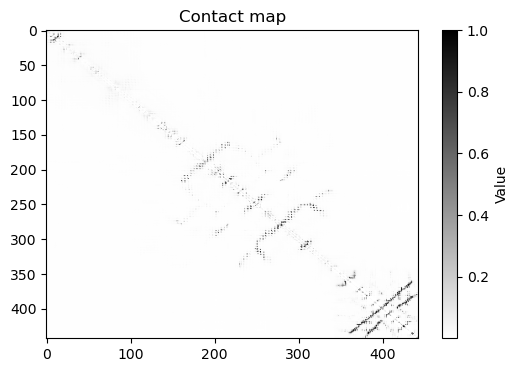

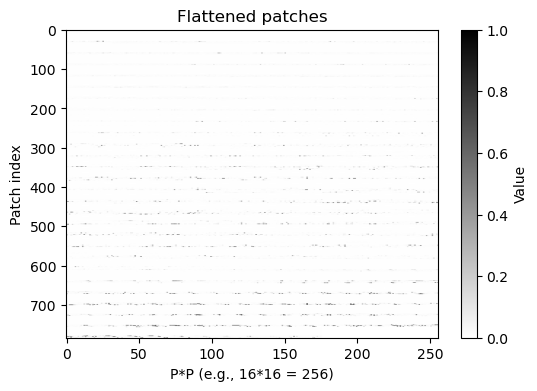

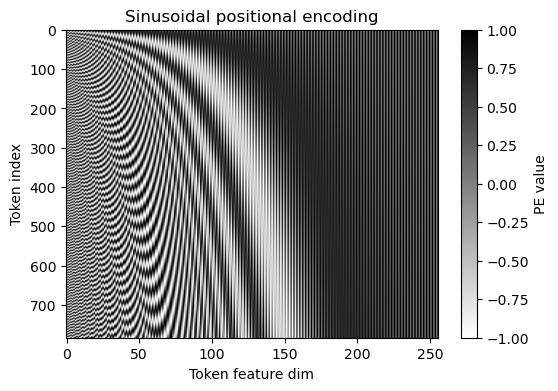

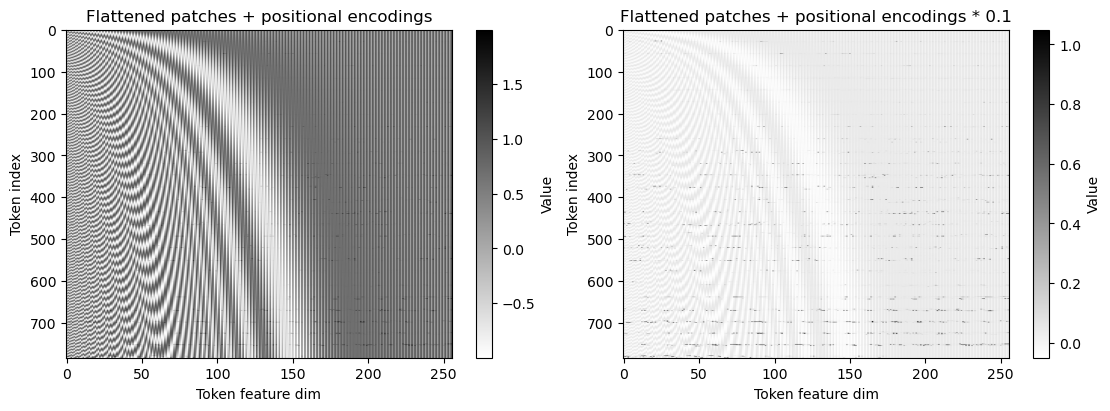

In [15]:
# --- sinusoidal PE ---
def get_sinusoid_encoding(num_tokens: int, token_len: int) -> torch.FloatTensor:
    """
    Make sinusoidal position encoding table.

    Args:
        num_tokens (int): number of tokens (sequence length, L)
        token_len (int): token feature dimension (D)

    Returns:
        torch.FloatTensor of shape [1, L, D]
    """
    def get_position_angle_vec(i):
        return [i / np.power(10000, 2 * (j // 2) / token_len) for j in range(token_len)]

    sinusoid_table = np.array([get_position_angle_vec(i) for i in range(num_tokens)], dtype=np.float32)
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return torch.from_numpy(sinusoid_table).unsqueeze(0)  # [1, L, D]

# --- params & data ---
p = 16  # patch size
#6M9S_0_A_6M9S_0_B
cont_np = np.load("/work3/s232958/data/PPint_DB/binders_contacts/6M9S_0_B.npy")  # [N, N], float or int

# --- Contact map ---
fig = plt.figure(figsize=(6, 4))
plt.title('Contact map')
im = plt.imshow(cont_np, cmap='gray_r', aspect='auto')
fig.colorbar(im, ax=plt.gca(), label='Value')

# --- Torch tensor prep (NCHW) ---
x = torch.tensor(cont_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1, 1, N, N]

N = cont_np.shape[0]
H = ((N + p - 1) // p) * p   # next multiple of p
ph = H - N                   # pad amount for right & bottom

# pad order in F.pad is (left, right, top, bottom)
x = F.pad(x, (0, ph, 0, ph), value=0.0)  # [1, 1, H, H]

# --- Patchify (non-overlapping p x p) ---
unfold = nn.Unfold(kernel_size=p, stride=p)
patches = unfold(x)                            # [N, C*p*p, L] --> [1, 1*p*p, L] N - # of images (1), C - # of channels (1), L - # of patches 
tokens = patches.squeeze(0).transpose(0, 1)    # [L, p*p] -> [L, D]
tokens = tokens.contiguous()

# --- Visualize flattened patches ---
fig = plt.figure(figsize=(6, 4))
plt.title('Flattened patches')
plt.xlabel(f'P*P (e.g., {p}*{p} = {p*p})')
plt.ylabel('Patch index')
im = plt.imshow(tokens.cpu().numpy(), cmap='gray_r', aspect='auto')
fig.colorbar(im, ax=plt.gca(), label='Value')

# --- Ensure feature dim is 256 (p=16 -> 256) ---
D_target = p*p
L, D = tokens.shape
if D < D_target:
    feat_pad = torch.zeros(L, D_target - D, dtype=tokens.dtype, device=tokens.device)
    tokens = torch.cat([tokens, feat_pad], dim=1)
elif D > D_target:
    tokens = tokens[:, :D_target]
# now tokens is [L, 256]

# --- Positional encodings ---
positional_embedding = get_sinusoid_encoding(num_tokens=tokens.shape[0], token_len=tokens.shape[1])  # [1, L, 256]
pe = positional_embedding.squeeze(0)  # [L, 256]

# visualize PE
fig = plt.figure(figsize=(6, 4))
plt.title('Sinusoidal positional encoding')
plt.xlabel('Token feature dim')
plt.ylabel('Token index')
im = plt.imshow(pe.cpu().numpy(), cmap='gray_r', aspect='auto', vmin=-1, vmax=1)
fig.colorbar(im, ax=plt.gca(), label='PE value')

# --- Add PE to tokens (no normalization here) ---
# --- Add PE to tokens (no normalization here) ---
flat1 = tokens + pe            # [L, 256]
flat2 = tokens + pe * 0.05     # [L, 256]

arr1 = flat1.detach().cpu().numpy()
arr2 = flat2.detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)

# Panel 1
im1 = axes[0].imshow(arr1, cmap='gray_r', aspect='auto')
axes[0].set_title('Flattened patches + positional encodings')
axes[0].set_xlabel('Token feature dim')
axes[0].set_ylabel('Token index')
fig.colorbar(im1, ax=axes[0], label='Value')

# Panel 2
im2 = axes[1].imshow(arr2, cmap='gray_r', aspect='auto')
axes[1].set_title('Flattened patches + positional encodings * 0.1')
axes[1].set_xlabel('Token feature dim')
axes[1].set_ylabel('Token index')
fig.colorbar(im2, ax=axes[1], label='Value')

plt.show()

- Flattened patches are very low-magnitude & sparse (values ~0–1, mostly near 0).
- Sinusoidal PE is large and dense (±1 across all dims).
- In the bottom panel, **PE visually dominates** the token values once added. That means attention mostly “sees” the sinusoid, not your contact signal.

### PPint dataloader

In [16]:
Df_test.seq_binder_len.max()
Df_test.seq_target_len.max()

458

In [17]:
# Df_test["seq_binder_len"].min()
# Df_test["seq_target_len"].min()
# Df_train["seq_binder_len"].min()
# Df_train["seq_target_len"].min()

In [18]:
class CLIP_PPint_analysis_dataset(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=1280,
        embedding_pad_value=-5000.0,
        structure_pad_value=0.0,
        p=16
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = embedding_dim
        self.emb_pad = embedding_pad_value
        self.struct_pad = structure_pad_value
        self.p = p

        # lengths
        self.max_blen = self.dframe["seq_binder_len"].max()
        self.max_tlen = self.dframe["seq_target_len"].max()

        # patch extractor
        # patchify --> flatten each patch to p*p dim=1 --> stack pacthes
        # self.unfold = nn.Unfold(kernel_size=self.p, stride=self.p)
        self.unfold = nn.Unfold(kernel_size=self.p, stride=p)

        # paths
        self.encoding_bpath, self.encoding_tpath, self.contacts_bpath, self.contacts_tpath = paths

        # index & storage
        self.dframe.set_index("target_binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = "_".join(parts[:3])
            bnd_id = "_".join(parts[3:])

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_tpath, f"{tgt_id}.npy"))     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_bpath, f"{bnd_id}.npy"))     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            ### --- contacts → tokens (zero pad for patching, unfold, add sinusoid PE, pad to global patch indeces length) --- ###
            
            t_cont = np.load(os.path.join(self.contacts_tpath, f"{tgt_id}.npy"))    # [Lt, Lt]
            b_cont = np.load(os.path.join(self.contacts_bpath, f"{bnd_id}.npy"))    # [Lb, Lb]

            t_tok = self._contact_to_tokens(t_cont)                  # [L_s_t, p*p]
            b_tok = self._contact_to_tokens(b_cont)                  # [L_s_b, p*p]

            self.samples.append((b_emb, t_emb, b_tok, t_tok))

    def _contact_to_tokens(self, cont_np: np.ndarray) -> torch.Tensor:
        """
        Purpose: return flattened stacked patches
        """        
        # to NCHW
        x = torch.from_numpy(cont_np).float()[None, None, ...]   # [1,1,N,N]

        # zero-pad right and bototm to be divisible by p
        N = cont_np.shape[0]
        Hs = ((N + self.p - 1) // self.p) * self.p
        pad = Hs - N
        x = F.pad(x, (0, pad, 0, pad), value=0.0) # [1,1,Hs,Hs]

        # unfold to non-overlapping p×p
        # squeeze [1, p*p, Ls] --> transpose [p*p, Ls] --> [Ls, p*p]
        cols = self.unfold(x).squeeze(0).transpose(0, 1).contiguous()  
        return cols

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr, b_tok, t_tok = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        binder_ct, target_ct = b_tok.float(), t_tok.float()
        label = torch.tensor(1, dtype=torch.float32)  # single scalar labe
        return binder_emb, target_emb, binder_ct, target_ct, label

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, bct_list, tct_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Keep contacts as lists
        bct = [torch.as_tensor(x) for x in bct_list]
        tct = [torch.as_tensor(x) for x in tct_list]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, bct, tct, labels

In [19]:
bemb_path = "/work3/s232958/data/PPint_DB/binders_embeddings_esm2"
temb_path = "/work3/s232958/data/PPint_DB/targets_embeddings_esm2"

## Contact maps paths
bcont_path = "/work3/s232958/data/PPint_DB/binders_contacts"
tcont_path = "/work3/s232958/data/PPint_DB/targets_contacts"

# global_max_blen = int(PPint_interaactions_df["seq_binder_len"].max())
# global_max_tlen = int(PPint_interaactions_df["seq_target_len"].max())

training_Dataset = CLIP_PPint_analysis_dataset(
    Df_train,
    paths=[bemb_path, temb_path, bcont_path, tcont_path],
    embedding_dim=1280
)

testing_Dataset = CLIP_PPint_analysis_dataset(
    Df_test,
    paths=[bemb_path, temb_path, bcont_path, tcont_path],
    embedding_dim=1280
)

#Loading ESM2 embeddings and contacts: 100%|██████████████████████████████████████████| 494/494 [00:05<00:00, 83.85it/s]


In [20]:
### Getting indeces of non-dimers
indices_non_dimers_val = Df_test[~Df_test["dimer"]].index.tolist()
indices_non_dimers_val[:5]

### Getting accessions of non-dimers
accessions = [Df_test.loc[index].target_binder_id for index in indices_non_dimers_val]
b, t, bct, tct, labels = testing_Dataset._get_by_name(accessions[:5])
labels

tensor([1., 1., 1., 1., 1.])

In [21]:
b, t, bct, tct, labels = testing_Dataset._get_by_name(accessions)

for a, b, c, d, e in zip(b, t, bct, tct, labels):
    print(a.shape, b.shape, c.shape, d.shape, e)
    break

torch.Size([459, 1280]) torch.Size([458, 1280]) torch.Size([4, 256]) torch.Size([9, 256]) tensor(1.)


### Loading Meta-analysis dataset for validation

In [22]:
interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal.csv")[["A_seq", "B_seq", "target_id_mod", "target_binder_ID", "binder"]].rename(columns = {
    "A_seq" : "seq_binder",
    "B_seq" : "seq_target",
    "target_binder_ID" : "binder_id",
    "target_id_mod" : "target_id",
    "binder" : "binder_label"
})
interaction_df["seq_target_len"] = [len(seq) for seq in interaction_df["seq_target"].tolist()]
interaction_df["seq_binder_len"] = [len(seq) for seq in interaction_df["seq_binder"].tolist()]

# Targets df
target_df = interaction_df[["target_id","seq_target"]].rename(columns={"seq_target":"sequence", "target_id" : "ID"})
target_df["seq_len"] = target_df["sequence"].apply(len)
target_df = target_df.drop_duplicates(subset=["ID","sequence"])
target_df = target_df.set_index("ID")

# Binders df
binder_df = interaction_df[["binder_id","seq_binder"]].rename(columns={"seq_binder":"sequence", "binder_id" : "ID"})
binder_df["seq_len"] = binder_df["sequence"].apply(len)
binder_df = binder_df.set_index("ID")

# target_df

# Interaction Dict
interaction_Dict = dict(enumerate(zip(interaction_df["target_id"], interaction_df["binder_id"]), start=1))
interaction_df_shuffled = interaction_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
interaction_df_shuffled

,seq_binder,seq_target,target_id,binder_id,binder_label,seq_target_len,seq_binder_len
0,DIVEEAHKLLSRAMSEAMENDDPDKLRRANELYFKLEEALKNNDPK...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_124,True,101,62
1,SEELVEKVVEEILNSDLSNDQKILETHDRLMELHDQGKISKEEYYK...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,EGFR_2,EGFR_2_149,False,621,58
2,TINRVFHLHIQGDTEEARKAHEELVEEVRRWAEELAKRLNLTVRVT...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_339,False,101,65
3,DDLRKVERIASELAFFAAEQNDTKVAFTALELIHQLIRAIFHNDEE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1234,False,101,64
4,DEEVEELEELLEKAEDPRERAKLLRELAKLIRRDPRLRELATEVVA...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_48,False,165,65
...,...,...,...,...,...,...,...
3527,SEDELRELVKEIRKVAEKQGDKELRTLWIEAYDLLASLWYGAADEL...,TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFK...,SARS_CoV2_RBD,SARS_CoV2_RBD_25,False,195,63
3528,TEEEILKMLVELTAHMAGVPDVKVEIHNGTLRVTVNGDTREARSVL...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2027,False,101,65
3529,VEELKEARKLVEEVLRKKGDQIAEIWKDILEELEQRYQEGKLDPEE...,DYSFSCYSQLEVNGSQHSLTCAFEDPDVNTTNLEFEICGALVEVKC...,IL7Ra,IL7Ra_90,False,193,63
3530,DAEEEIREIVEKLNDPLLREILRLLELAKEKGDPRLEAELYLAFEK...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1605,False,101,65


In [23]:
class CLIP_Meta_analysis_dataset(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=1280,
        embedding_pad_value=-5000.0,
        structure_pad_value=0.0,
        p=16,
        fixed_max_blen=None,
        fixed_max_tlen=None,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)
        self.struct_pad = float(structure_pad_value)
        self.p = int(p)

        # lengths
        self.max_blen = self.dframe["seq_binder_len"].max()
        self.max_tlen = self.dframe["seq_target_len"].max()

        # patch extractor
        # patchify --> flatten each patch to p*p dim=1 --> stack pacthes
        self.unfold = nn.Unfold(kernel_size=self.p, stride=self.p)

        # paths
        self.encoding_bpath, self.encoding_tpath, self.contacts_bpath, self.contacts_tpath = paths

        # index & storage
        self.dframe.set_index("binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            lbl = torch.tensor(int(self.dframe.loc[accession, "binder_label"]))
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = "_".join(parts[:-1])
            bnd_id = accession

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_tpath, f"{tgt_id}.npy"))     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_bpath, f"{bnd_id}.npy"))     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            ### --- contacts → tokens (zero pad for patching, unfold, add sinusoid PE, pad to global patch indeces length) --- ###
            
            t_cont = np.load(os.path.join(self.contacts_tpath, f"{tgt_id}.npy"))    # [Lt, Lt]
            b_cont = np.load(os.path.join(self.contacts_bpath, f"{bnd_id}.npy"))    # [Lb, Lb]

            t_tok = self._contact_to_tokens(t_cont)                  # [L_s_t, p*p]
            b_tok = self._contact_to_tokens(b_cont)                  # [L_s_b, p*p]

            self.samples.append((b_emb, t_emb, b_tok, t_tok, lbl))

    def _contact_to_tokens(self, cont_np: np.ndarray) -> torch.Tensor:
        """
        Purpose: return flattened stacked patches
        """        
        # to NCHW
        x = torch.from_numpy(cont_np).float()[None, None, ...]   # [1,1,N,N]

        # zero-pad right and bototm to be divisible by p
        N = cont_np.shape[0]
        Hs = ((N + self.p - 1) // self.p) * self.p
        pad = Hs - N
        x = F.pad(x, (0, pad, 0, pad), value=0.0) # [1,1,Hs,Hs]

        # unfold to non-overlapping p×p
        # squeeze [1, p*p, Ls] --> transpose [p*p, Ls] --> [Ls, p*p]
        cols = self.unfold(x).squeeze(0).transpose(0, 1).contiguous()  
        return cols
        
    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr, b_tok, t_tok, lbls = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        binder_ct, target_ct = b_tok.float(), t_tok.float()
        return binder_emb, target_emb, binder_ct, target_ct, lbls

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, bct_list, tct_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Keep contacts as lists
        bct = [torch.as_tensor(x) for x in bct_list]
        tct = [torch.as_tensor(x) for x in tct_list]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, bct, tct, labels

bemb_path = "/work3/s232958/data/meta_analysis/binders_embeddings_esm2"
temb_path = "/work3/s232958/data/meta_analysis/targets_embeddings_esm2"

## Contact maps paths
bcont_path = "/work3/s232958/data/meta_analysis/binders_contacts"
tcont_path = "/work3/s232958/data/meta_analysis/targets_contacts"

validation_Dataset = CLIP_Meta_analysis_dataset(
    interaction_df_shuffled,
    paths=[bemb_path, temb_path, bcont_path, tcont_path],
    embedding_dim=1280
)

#Loading ESM2 embeddings and contacts: 100%|███████████████████████████████████████| 3532/3532 [00:30<00:00, 115.51it/s]


In [24]:
accs = []
for i, row in interaction_df_shuffled[:100].iterrows():
    if i % 11 == 0:
        accs.append(row.binder_id)
print(accs)
__, __, __, __, lbls = validation_Dataset._get_by_name(accs)
lbls

['FGFR2_124', 'Pdl1_49', 'Mdm2_41', 'FGFR2_1194', 'FGFR2_798', 'FGFR2_1731', 'FGFR2_25', 'InsulinR_74', 'IL7Ra_80', 'FGFR2_967']


tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

### CLIP-model (validation with meta-dataset)

In [25]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    """
    Purpose: return vector indicating which rows are not padded (don't have values = -5000)
    """
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1280] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

def get_sinusoid_encoding(num_tokens, token_len):
    """
    Purpose: positional encoding having the same dimensions as token matrix
    Standard Vaswani sinusoidal positional encoding for a sequence of length L=num_tokens and dim D=token_len.
    Returns: [L, D] tensor (no batch dim).
    """
    device = torch.device("cpu")
    L, D = num_tokens, token_len
    pos = torch.arange(L, dtype=torch.float32, device=device).unsqueeze(1)      # [L,1]
    i   = torch.arange(D, dtype=torch.float32, device=device).unsqueeze(0)      # [1,D]
    div = torch.pow(10000.0, (2 * torch.floor(i/2)) / D)                        # [1,D]
    angles = pos / div                                                          # [L,D]
    pe = torch.zeros(L, D, dtype=torch.float32, device=device)
    pe[:, 0::2] = torch.sin(angles[:, 0::2])
    pe[:, 1::2] = torch.cos(angles[:, 1::2])
    return pe

def pad_tokens_to_L(tokens: torch.Tensor, L_target: int):
    if tokens.dim() == 3:
        B, Ls, D = tokens.shape
        if Ls >= L_target:
            return tokens[:, :L_target, :]
        pad = tokens.new_zeros(B, L_target - Ls, D)
        return torch.cat([tokens, pad], dim=1)
    elif tokens.dim() == 2:
        Ls, D = tokens.shape
        if Ls >= L_target:
            return tokens[:L_target]
        pad = tokens.new_zeros(L_target - Ls, D)
        return torch.cat([tokens, pad], dim=0)
    else:
        raise ValueError(f"Unexpected tokens.dim()={tokens.dim()} (wanted 2 or 3)")

`trained/PPint_retrain10%_0.4_Christian_w_structure/8e6bf541-1f8e-4f66-9d14-0c0b7327765b_checkpoint_3/...`
#### 1. Prep:
- project contact maps to match dim=1280
- add positional encoding using func `get_sinusoid_encoding()`
- pad so that all contact maps would be the same length (use max_target_len, max_binder_len)
- padding mask for all: embeddings, contact maps

#### 2. Flow:
- seq_Trans, struct_Trans (self-attention)
- cross-attention (pep(prot)/struct): struct_to_seq_attn --> update pep/prot trans_embed
- cross-attention (pep/prot)  

In [26]:
class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(
        self,
        padding_value=-5000,
        seq_embed_dimension = seq_embed_dimension,
        struct_embed_dimension = struct_embed_dimension,
        num_recycles=2
    ):
        super().__init__()
        self.num_recycles = num_recycles # 2
        self.padding_value = padding_value # -5000
        self.seq_embed_dimension = seq_embed_dimension # 1280
        self.struct_embed_dimension = struct_embed_dimension # 256

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init
        self.struct_alpha = nn.Parameter(torch.tensor(0.0))
        self.pe_scale = nn.Parameter(torch.tensor(0.1))

        ### SEQUENCE ###
        # self attention
        self.seq_encoder = nn.TransformerEncoderLayer(
            d_model=self.seq_embed_dimension, 
            nhead=8,
            dropout=0.1, 
            batch_first=True, 
            dim_feedforward=self.seq_embed_dimension)

        self.norm_seq = nn.LayerNorm(self.seq_embed_dimension)  # For residual additions

        # cross attention
        self.seq_cross_attn = nn.MultiheadAttention(
            embed_dim=self.seq_embed_dimension, 
            num_heads=8,
            dropout=0.1, 
            batch_first=True)

        self.projection_head= nn.Sequential(
            nn.Linear(self.seq_embed_dimension, 640), 
            nn.ReLU(), 
            nn.Linear(640, 320))

        ### STRUCTURE ###
        
        # Linear projection of flat patches
        self.token_project = nn.Linear(
            self.struct_embed_dimension,
            self.seq_embed_dimension, 
            bias=True)

        self.norm_struct = nn.LayerNorm(self.seq_embed_dimension)  # For residual additions
        
        # self attention        
        self.struct_encoder = nn.TransformerEncoderLayer(
            d_model=self.seq_embed_dimension, 
            nhead=8,
            dropout=0.1, 
            batch_first=True, 
            dim_feedforward=self.seq_embed_dimension)

        self.struct_to_seq_attn = nn.MultiheadAttention(
            embed_dim=self.seq_embed_dimension, 
            num_heads=8,
            dropout=0.1, 
            batch_first=True)
                
    def forward(self, pep_emb, prot_emb, pep_contacts_list, prot_contacts_list, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True):

        pep_max_len, prot_max_len = max(x.size(0) for x in pep_contacts_list), max(x.size(0) for x in prot_contacts_list)
        
        ### nn.Linear() --> + PE -->padding to max token index 
        # 1. Linear projection of flat contacts
        pep_cm_proj  = [self.token_project(x.to(device)) for x in pep_contacts_list]
        prot_cm_proj  = [self.token_project(x.to(device)) for x in prot_contacts_list]
        del pep_contacts_list, prot_contacts_list
                
        # 2. + positional encoding (unchanged lists, but now scaled)
        pep_pe = [get_sinusoid_encoding(cm.shape[0], cm.shape[1]).to(device) for cm in pep_cm_proj]
        pep_cm_pos = [cm + self.pe_scale * pe for cm, pe in zip(pep_cm_proj, pep_pe)]
        
        prot_pe = [get_sinusoid_encoding(cm.shape[0], cm.shape[1]).to(device) for cm in prot_cm_proj]
        prot_cm_pos = [cm + self.pe_scale * pe for cm, pe in zip(prot_cm_proj, prot_pe)]

        # 3. Pad dim=0 for batch
        pep_cm_pos = torch.stack([pad_tokens_to_L(cm, pep_max_len) for cm in pep_cm_pos], dim=0)
        prot_cm_pos = torch.stack([pad_tokens_to_L(cm, prot_max_len) for cm in prot_cm_pos], dim=0)
        
        # Key padding masks (True = pad -> to be ignored by attention)
        pep_mask_emb = create_key_padding_mask(embeddings = pep_emb, padding_value = self.padding_value).to(device)   # [B, Lp]
        prot_mask_emb = create_key_padding_mask(embeddings = prot_emb, padding_value = self.padding_value).to(device)    # [B, Lt]
        
        pep_mask_cm = create_key_padding_mask(embeddings = pep_cm_pos, padding_value = self.padding_value).to(device)     # [B, Lp_cm]
        prot_mask_cm = create_key_padding_mask(embeddings = prot_cm_pos, padding_value = self.padding_value).to(device)     # [B, Lt_cm]
    
        # Residual states
        pep_emb = pep_emb.to(device)
        prot_emb = prot_emb.to(device)
        pep_contacts = pep_cm_pos.to(device)
        prot_contacts = prot_cm_pos.to(device)
        # pep_emb, prot_emb, pep_contacts, prot_contacts = pep_emb.clone(), prot_emb.clone(), pep_cm_pos.clone(), prot_cm_pos.clone()
    
        for _ in range(self.num_recycles):
            
            # --- Self-attention encoders (embedding streams) ---
            pep_trans_emb = self.seq_encoder(self.norm_seq(pep_emb), src_key_padding_mask=pep_mask_emb)   # [B, Lp, E]
            prot_trans_emb = self.seq_encoder(self.norm_seq(prot_emb), src_key_padding_mask=prot_mask_emb)  # [B, Lt, E]
    
            # --- Self-attention encoders (structure streams) ---
            pep_trans_cm = self.struct_encoder(self.norm_struct(pep_contacts), src_key_padding_mask=pep_mask_cm)   # [B, Lp_cm, E]
            prot_trans_cm = self.struct_encoder(self.norm_struct(prot_contacts), src_key_padding_mask=prot_mask_cm)  # [B, Lt_cm, E]

            # --- Cross-attend to structures ---
            pep_struct_upd, _ = self.struct_to_seq_attn(query=self.norm_seq(pep_trans_emb), key=self.norm_struct(pep_trans_cm), value=self.norm_struct(pep_trans_cm), key_padding_mask=pep_mask_cm)
            prot_struct_upd, _ = self.struct_to_seq_attn(query=self.norm_seq(prot_trans_emb), key=self.norm_struct(prot_trans_cm), value=self.norm_struct(prot_trans_cm), key_padding_mask=prot_mask_cm)

            pep_trans_emb  = pep_trans_emb  + self.struct_alpha.tanh() * pep_struct_upd    # [B, Lp, E]
            prot_trans_emb = prot_trans_emb + self.struct_alpha.tanh() * prot_struct_upd    # [B, Lt, E]
    
            # --- Cross-attend binder vs target ---
            pep_cross,  _  = self.seq_cross_attn(query=self.norm_seq(pep_trans_emb), key=self.norm_seq(prot_trans_emb), value=self.norm_seq(prot_trans_emb), key_padding_mask=prot_mask_emb)
            prot_cross, _  = self.seq_cross_attn(query=self.norm_seq(prot_trans_emb), key=self.norm_seq(pep_trans_emb), value=self.norm_seq(pep_trans_emb), key_padding_mask=pep_mask_emb)
    
            # --- Residual updates ---
            pep_emb = pep_emb + pep_cross
            prot_emb = prot_emb + prot_cross
    
        # Pool (mean over non-masked positions)
        pep_seq_coding   = create_mean_of_non_masked(pep_emb, pep_mask_emb)
        prot_seq_coding  = create_mean_of_non_masked(prot_emb, prot_mask_emb)

        # Projections + L2-normalize
        pep_full   = F.normalize(self.projection_head(pep_seq_coding),   dim=-1)
        prot_full  = F.normalize(self.projection_head(prot_seq_coding),  dim=-1)
    
        if mem_save:
            torch.cuda.empty_cache()
    
        scale  = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_full * prot_full).sum(dim=-1)  # [B]

        del pep_emb, prot_emb, pep_contacts, prot_contacts
        
        return logits

    def training_step(self, batch, device):
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        # embedding_pep, embedding_prot, contacts_pep, contacts_prot = embedding_pep.to(device), embedding_prot.to(device), contacts_binder.to(device), contacts_prot.to(device)

        # loss of predicting partner using peptide
        positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device)) # F.binary_cross_entropy_with_logits does sigmoid transfromation inside, excepts data, labels
        
        # Negative indexes
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1) # upper triangle
        
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]

        # loss of predicting peptide using partner
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
        
        loss = (positive_loss + negative_loss) / 2
 
        # del partner_prediction_loss, peptide_prediction_loss, embedding_pep, embedding_prot
        torch.cuda.empty_cache()
        return loss

    def validation_step_PPint(self, batch, device):
        # Predict on random batches of training batch size
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        # contacts_pep, contacts_prot = contacts_pep.to(device), contacts_prot.to(device)
        
        with torch.no_grad():

            positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
            
            # loss of predicting partner using peptide
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
            
            # Negaive indexes
            rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)
            
            pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
            prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
            
            negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))

            loss = (positive_loss + negative_loss) / 2

            logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            
            # Fill diagonal with positive scores
            diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(embedding_prot.size(0)).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            
            # partner_accuracy = partner_predictions.eq(labels).float().mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            del logit_matrix,positive_logits,negative_logits,embedding_pep,embedding_prot

            return loss, peptide_accuracy
    
    def validation_step_MetaDataset(self, batch, device):
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        # contacts_pep, contacts_prot = contacts_pep.to(device), contacts_prot.to(device)
        labels = labels.to(device).float()
    
        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot).float()
            loss = F.binary_cross_entropy_with_logits(logits.view(-1), labels.view(-1))
            return logits, loss

    def calculate_logit_matrix(self, embedding_pep, embedding_prot, contacts_pep, contacts_prot):
        
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
        
        positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        return logit_matrix

### Train model from scratch with 10% of PPint dataset

In [27]:
model = MiniCLIP_w_transformer_crossattn(
    seq_embed_dimension=seq_embed_dimension,
    struct_embed_dimension=struct_embed_dimension,
    num_recycles=number_of_recycles
).to("cuda")

model

MiniCLIP_w_transformer_crossattn(
  (seq_encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
    )
    (linear1): Linear(in_features=1280, out_features=1280, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1280, out_features=1280, bias=True)
    (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm_seq): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  (seq_cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
  )
  (projection_head): Sequential(
    (0): Linear(in_features=1280, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features

### Trianing loop

In [28]:
def batch(iterable, n=1):
    """Takes any indexable iterable (e.g., a list of observation IDs) and yields contiguous slices of length n."""
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

class TrainWrapper():

    def __init__(self, 
                 model, 
                 train_loader,
                 test_loader,
                 val_loader,
                 test_df,
                 test_dataset,
                 optimizer, 
                 epochs, 
                 runID, 
                 device, 
                 test_indexes_for_auROC = None,
                 auROC_batch_size=10, 
                 model_save_steps=False, 
                 model_save_path=False, 
                 v=False, 
                 wandb_tracker=False):
        
        self.model = model 
        self.training_loader = train_loader
        self.testing_loader = test_loader
        self.validation_loader = val_loader
        self.test_dataset = test_dataset
        self.test_df = test_df
        self.auROC_batch_size = auROC_batch_size
        
        self.EPOCHS = epochs
        self.optimizer = optimizer
        self.device = device
        
        self.wandb_tracker = wandb_tracker
        self.model_save_steps = model_save_steps
        self.verbose = v
        self.best_vloss = 1_000_000
        self.runID = runID
        self.trained_model_dir = model_save_path
        self.print_frequency_loss = 1
        self.test_indexes_for_auROC = test_indexes_for_auROC

    def train_one_epoch(self):

        self.model.train() 
        running_loss = 0

        for batch in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):
            
            if batch[0].size(0) == 1: 
                continue
            
            self.optimizer.zero_grad()
            loss = self.model.training_step(batch, self.device)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

            del loss, batch
            torch.cuda.empty_cache()
            
        return running_loss / len(self.training_loader)

    def calc_auroc_aupr_on_indexes(self, model, dataset, dataframe, nondimer_indexes, batch_size = 10):

        self.model.eval()
        all_TP_scores, all_FP_scores = [], []
        accessions = [dataframe.loc[index].target_binder_id for index in nondimer_indexes]  # <-- use dataframe
        batches_local = batch(accessions, n=batch_size)
        
        with torch.no_grad():
            for index_batch in tqdm(batches_local, total=int(len(accessions)/batch_size), desc="Calculating AUC"):

                embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = dataset._get_by_name(index_batch)
                embedding_pep, embedding_prot = embedding_pep.to(self.device), embedding_prot.to(self.device)

                # Make sure this matches your model's signature:
                logit_matrix = self.model.calculate_logit_matrix(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
                
                TP_scores = logit_matrix.diag().detach().cpu().tolist()
                all_TP_scores += TP_scores
                
                # Get FP scores from upper triangle (excluding diagonal)
                n = logit_matrix.size(0)
                rows, cols = torch.triu_indices(n, n, offset=1)
                FP_scores = logit_matrix[rows, cols].detach().cpu().tolist()
                all_FP_scores += FP_scores
            
        all_score_predictions = np.array(all_TP_scores + all_FP_scores)
        all_labels = np.array([1]*len(all_TP_scores) + [0]*len(all_FP_scores))
                
        fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_score_predictions)
        auroc = metrics.roc_auc_score(all_labels, all_score_predictions)
        aupr  = metrics.average_precision_score(all_labels, all_score_predictions)
        
        return auroc, aupr, all_TP_scores, all_FP_scores

    def validate(self):
        
        self.model.eval()
        
        running_loss_Meta = 0.0
        all_logits = []
        all_lbls = []
        used_batches_meta = 0

        # --- MetaDataset validation ---
        with torch.no_grad():
            for batch in tqdm(self.validation_loader, total=len(self.validation_loader)):
                if batch[0].size(0) == 1:
                    continue
                __, __, __, __, labels = batch
                logits, loss = self.model.validation_step_MetaDataset(batch, self.device)
                
                running_loss_Meta += loss.item()
                all_logits.append(logits.detach().view(-1).cpu())
                all_lbls.append(labels.detach().view(-1).cpu())
                used_batches_meta += 1
                
            if used_batches_meta > 0:
                val_loss_Meta = running_loss_Meta / used_batches_meta
                all_logits = torch.cat(all_logits).numpy()
                all_lbls   = torch.cat(all_lbls).numpy()
            
                fpr, tpr, thresholds = metrics.roc_curve(all_lbls, all_logits)
                meta_auroc = metrics.roc_auc_score(all_lbls, all_logits)
                meta_aupr  = metrics.average_precision_score(all_lbls, all_logits)

                y_pred = (all_logits >= 0).astype(int)
                y_true = all_lbls.astype(int)
                val_acc_Meta = (y_pred == y_true).mean()
            else:
                val_loss_Meta = float("nan")
                meta_auroc = float("nan")
                meta_aupr = float("nan")
                val_acc_Meta = float("nan")

        # --- PPint validation ---
        running_loss_ValPPint = 0.0
        running_accuracy_ValPPint = 0.0
        used_batches_ppint = 0

        with torch.no_grad():
            for batch in tqdm(self.testing_loader, total=len(self.testing_loader)):
                if batch[0].size(0) == 1:
                    continue
                loss, partner_accuracy = self.model.validation_step_PPint(batch, self.device)
                running_loss_ValPPint += loss.item()
                running_accuracy_ValPPint += partner_accuracy.item()
                used_batches_ppint += 1
                
            if used_batches_ppint > 0:
                val_loss_PPint = running_loss_ValPPint / used_batches_ppint
                val_accuracy_PPint = running_accuracy_ValPPint / used_batches_ppint
            else:
                val_loss_PPint = float("nan")
                val_accuracy_PPint = float("nan")

        # --- AUROC on specific indexes (optional) ---
        if self.test_indexes_for_auROC is not None:
            non_dimer_auc, non_dimer_aupr, ___, ___ = self.calc_auroc_aupr_on_indexes(
                model=self.model, 
                dataset=self.test_dataset,
                dataframe=self.test_df,
                nondimer_indexes=self.test_indexes_for_auROC,
                batch_size=self.auROC_batch_size
            )
            
            return (val_loss_PPint, val_accuracy_PPint,
                    non_dimer_auc, non_dimer_aupr,
                    val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr)

        else:
            return (val_loss_PPint, val_accuracy_PPint,
                    val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr)

    def train_model(self):
        
        torch.cuda.empty_cache()
        
        if self.verbose:
            print(f"Training model {str(self.runID)}")

        # --- initial validation before training
        print("Initial validation before starting training")
        if self.test_indexes_for_auROC is not None:
            (val_loss_PPint, val_accuracy_PPint,
             non_dimer_auc, non_dimer_aupr,
             val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr) = self.validate()
        else:
            (val_loss_PPint, val_accuracy_PPint,
             val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr) = self.validate()
            non_dimer_auc, non_dimer_aupr = None, None
                
        if self.verbose: 
            print(f'Before training:')
            print(f'Meta Val-Loss {round(val_loss_Meta,4)}')
            print(f'Meta Accuracy: {round(val_acc_Meta,4)}')
            print(f'Meta AUROC: {round(meta_auroc,4)}')
            print(f'Meta AUPR: {round(meta_aupr,4)}')
            print(f'PPint Test-Loss: {round(val_loss_PPint,4)}')
            print(f'PPint Accuracy: {round(val_accuracy_PPint,4)}')
            if non_dimer_auc is not None:
                print(f'PPint non-dimer AUROC: {round(non_dimer_auc,4)}')
                print(f'PPint non-dimer AUPR: {round(non_dimer_aupr,4)}')
        
        if self.wandb_tracker:
            metrics_to_log = {
                "PPint Test-Loss": val_loss_PPint,
                "Meta Val-loss": val_loss_Meta,
                "PPint Accuracy": val_accuracy_PPint,
                "Meta Accuracy": val_acc_Meta,
                "Meta Val-AUROC": meta_auroc,
                "Meta Val-AUPR": meta_aupr,
            }
            if non_dimer_auc is not None:
                metrics_to_log.update({
                    "PPint non-dimer AUROC": non_dimer_auc,
                    "PPint non-dimer AUPR": non_dimer_aupr,
                })
            self.wandb_tracker.log(metrics_to_log)
        
        # --- training loop
        for epoch in tqdm(range(1, self.EPOCHS + 1), total=self.EPOCHS, desc="Epochs"):
            
            torch.cuda.empty_cache()
            
            train_loss = self.train_one_epoch()
            
            # validation after epoch
            if self.test_indexes_for_auROC is not None:
                (val_loss_PPint, val_accuracy_PPint,
                 non_dimer_auc, non_dimer_aupr,
                 val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr) = self.validate()
            else:
                (val_loss_PPint, val_accuracy_PPint,
                 val_loss_Meta, val_acc_Meta, meta_auroc, meta_aupr) = self.validate()
                non_dimer_auc, non_dimer_aupr = None, None
            
            torch.cuda.empty_cache()
            
            # checkpoint save
            if self.model_save_steps and epoch % self.model_save_steps == 0:
                check_point_folder = os.path.join(self.trained_model_dir, f"{str(self.runID)}_checkpoint_{str(epoch)}")
                if self.verbose:
                    print("Saving model to:", check_point_folder)
                os.makedirs(check_point_folder, exist_ok=True)
                checkpoint_path = os.path.join(check_point_folder, f"{str(self.runID)}_checkpoint_epoch_{str(epoch)}.pth")
                torch.save({'epoch': epoch, 
                            'model_state_dict': self.model.state_dict(),
                            'optimizer_state_dict': self.optimizer.state_dict(), 
                            'val_loss_PPint': val_loss_PPint,
                            'val_loss_Meta': val_loss_Meta},
                           checkpoint_path)
            
            # console logging
            if self.verbose and epoch % self.print_frequency_loss == 0:
                print(f'EPOCH {epoch}:')
                print(f'Meta Val Loss {round(val_loss_Meta,4)}')
                print(f'Meta Accuracy: {round(val_acc_Meta,4)}')
                print(f'Meta AUROC: {round(meta_auroc,4)}')
                print(f'Meta AUPR: {round(meta_aupr,4)}')
                print(f'PPint Test-Loss: {round(val_loss_PPint,4)}')
                print(f'PPint Accuracy: {round(val_accuracy_PPint,4)}')
                if non_dimer_auc is not None:
                    print(f'PPint non-dimer AUROC: {round(non_dimer_auc,4)}')
                    print(f'PPint non-dimer AUPR: {round(non_dimer_aupr,4)}')
            
            # wandb logging
            if self.wandb_tracker:
                metrics_to_log_epoch = {
                    "PPint Train-loss": train_loss,
                    "PPint Test-Loss": val_loss_PPint,
                    "Meta Val-loss": val_loss_Meta,
                    "PPint Accuracy": val_accuracy_PPint,
                    "Meta Accuracy": val_acc_Meta,
                    "Meta Val-AUROC": meta_auroc,
                    "Meta Val-AUPR": meta_aupr,
                }
                if non_dimer_auc is not None:
                    metrics_to_log_epoch.update({
                        "PPint non-dimer AUROC": non_dimer_auc,
                        "PPint non-dimer AUPR": non_dimer_aupr,
                    })
                self.wandb_tracker.log(metrics_to_log_epoch)

        if self.wandb_tracker:
            self.wandb_tracker.finish()

In [29]:
def collate_varlen(batch):
    b_emb = torch.stack([x[0] for x in batch], dim=0)  # fixed length -> stack
    t_emb = torch.stack([x[1] for x in batch], dim=0)
    b_ctok = [x[2] for x in batch]                     # var-len -> list
    t_ctok = [x[3] for x in batch]
    # lbls = torch.tensor([float(x[4]) for x in batch])
    lbls = torch.tensor([x[4].float() for x in batch])
    return b_emb, t_emb, b_ctok, t_ctok, lbls

train_dataloader = DataLoader(training_Dataset, batch_size=3, collate_fn=collate_varlen)
test_dataloader = DataLoader(testing_Dataset, batch_size=3, collate_fn=collate_varlen)
val_dataloader = DataLoader(validation_Dataset, batch_size=20, shuffle=False, drop_last = False, collate_fn=collate_varlen)

In [30]:
for i in val_dataloader:
    __, __, __, __, lbls = i
    print(lbls.to(device))
    break

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0')


In [31]:
runID = uuid.uuid4()
learning_rate = 2e-5
EPOCHS = 15
batch_size = 3
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
g = torch.Generator().manual_seed(SEED)

optimizer = AdamW(model.parameters(), lr=learning_rate)

# accelerator
accelerator = Accelerator()
model, optimizer, train_dataloader, test_dataloader, val_dataloader = accelerator.prepare(model, optimizer, train_dataloader, test_dataloader, val_dataloader)

device = accelerator.device

trained_model_dir = f"/work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_{runID}"
model_save_steps = 1

In [32]:
# wandb
if use_wandb:
    run = wandb.init(
        project="CLIP_retrain_w_10percent_of_PPint",
        name=f"PPint0.1_PPint_test_meta_val_w_struct_{runID}",
        config={"learning_rate": learning_rate, 
                "batch_size": batch_size, 
                "epochs": EPOCHS,
                "architecture": "MiniCLIP_w_transformer_crossattn", 
                "dataset": 
                "PPint"},
    )
    wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
else:
    run = None

# train
training_wrapper = TrainWrapper(
            model=model,
            train_loader=train_dataloader,
            test_loader=test_dataloader,
            val_loader=val_dataloader,
            test_df=Df_test,
            test_dataset=testing_Dataset,
            optimizer=optimizer,
            epochs=EPOCHS,
            runID=runID,
            device=device,
            test_indexes_for_auROC=indices_non_dimers_val,
            auROC_batch_size=10,
            model_save_steps=model_save_steps,
            model_save_path=trained_model_dir,
            v=True,
            wandb_tracker=wandb
)

training_wrapper.train_model() # start training

Training model 5a5a437d-0403-4209-b8c4-09eaf5bda508
Initial validation before starting training


Calculating AUC: 100%|██████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.33it/s]


Before training:
Meta Val-Loss 10.3996
Meta Accuracy: 0.1107
Meta AUROC: 0.512
Meta AUPR: 0.1273
PPint Test-Loss: 6.1825
PPint Accuracy: 0.8667
PPint non-dimer AUROC: 0.6465
PPint non-dimer AUPR: 0.3902


Running through epoch: 100%|██████████████████████████████████████████████████████████| 660/660 [02:56<00:00,  3.73it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:23<00:00,  2.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 165/165 [00:17<00:00,  9.37it/s]

Calculating AUC: 100%|██████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.33it/s]


Saving model to: /work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_5a5a437d-0403-4209-b8c4-09eaf5bda508/5a5a437d-0403-4209-b8c4-09eaf5bda508_checkpoint_1


Epochs:   7%|████▊                                                                    | 1/15 [04:48<1:07:15, 288.26s/it]

EPOCH 1:
Meta Val Loss 0.3906
Meta Accuracy: 0.8848
Meta AUROC: 0.4902
Meta AUPR: 0.1134
PPint Test-Loss: 0.3225
PPint Accuracy: 0.9273
PPint non-dimer AUROC: 0.7192
PPint non-dimer AUPR: 0.3798



Running through epoch: 100%|██████████████████████████████████████████████████████████| 660/660 [02:55<00:00,  3.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:21<00:00,  2.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 165/165 [00:15<00:00, 10.40it/s]

Calculating AUC: 100%|██████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.34it/s]


Saving model to: /work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_5a5a437d-0403-4209-b8c4-09eaf5bda508/5a5a437d-0403-4209-b8c4-09eaf5bda508_checkpoint_2


Epochs:  13%|█████████▋                                                               | 2/15 [09:31<1:01:45, 285.03s/it]

EPOCH 2:
Meta Val Loss 0.4266
Meta Accuracy: 0.8882
Meta AUROC: 0.4941
Meta AUPR: 0.1174
PPint Test-Loss: 0.2471
PPint Accuracy: 0.9374
PPint non-dimer AUROC: 0.7355
PPint non-dimer AUPR: 0.431



Running through epoch: 100%|██████████████████████████████████████████████████████████| 660/660 [02:53<00:00,  3.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:19<00:00,  2.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 165/165 [00:15<00:00, 10.42it/s]

Calculating AUC: 100%|██████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.35it/s]


Saving model to: /work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_5a5a437d-0403-4209-b8c4-09eaf5bda508/5a5a437d-0403-4209-b8c4-09eaf5bda508_checkpoint_3


Epochs:  20%|███████████████                                                            | 3/15 [14:09<56:25, 282.15s/it]

EPOCH 3:
Meta Val Loss 0.3943
Meta Accuracy: 0.8766
Meta AUROC: 0.4873
Meta AUPR: 0.1055
PPint Test-Loss: 0.2418
PPint Accuracy: 0.9535
PPint non-dimer AUROC: 0.7494
PPint non-dimer AUPR: 0.4161



Running through epoch: 100%|██████████████████████████████████████████████████████████| 660/660 [02:52<00:00,  3.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:19<00:00,  2.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 165/165 [00:15<00:00, 10.41it/s]

Calculating AUC: 100%|██████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.35it/s]


Saving model to: /work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_5a5a437d-0403-4209-b8c4-09eaf5bda508/5a5a437d-0403-4209-b8c4-09eaf5bda508_checkpoint_4


Epochs:  27%|████████████████████                                                       | 4/15 [18:47<51:26, 280.55s/it]

EPOCH 4:
Meta Val Loss 0.4359
Meta Accuracy: 0.8378
Meta AUROC: 0.5317
Meta AUPR: 0.1287
PPint Test-Loss: 0.3928
PPint Accuracy: 0.9394
PPint non-dimer AUROC: 0.7407
PPint non-dimer AUPR: 0.4361



Running through epoch: 100%|██████████████████████████████████████████████████████████| 660/660 [02:52<00:00,  3.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:19<00:00,  2.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 165/165 [00:15<00:00, 10.42it/s]

Calculating AUC: 100%|██████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.35it/s]


Saving model to: /work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_5a5a437d-0403-4209-b8c4-09eaf5bda508/5a5a437d-0403-4209-b8c4-09eaf5bda508_checkpoint_5


Epochs:  33%|█████████████████████████                                                  | 5/15 [23:25<46:36, 279.68s/it]

EPOCH 5:
Meta Val Loss 0.4301
Meta Accuracy: 0.872
Meta AUROC: 0.4821
Meta AUPR: 0.1019
PPint Test-Loss: 0.2225
PPint Accuracy: 0.9455
PPint non-dimer AUROC: 0.7377
PPint non-dimer AUPR: 0.444



Running through epoch: 100%|██████████████████████████████████████████████████████████| 660/660 [02:54<00:00,  3.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:20<00:00,  2.21it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 165/165 [00:16<00:00, 10.17it/s]

Calculating AUC: 100%|██████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.32it/s]


Saving model to: /work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_5a5a437d-0403-4209-b8c4-09eaf5bda508/5a5a437d-0403-4209-b8c4-09eaf5bda508_checkpoint_6


Epochs:  40%|██████████████████████████████                                             | 6/15 [28:06<42:00, 280.07s/it]

EPOCH 6:
Meta Val Loss 0.8729
Meta Accuracy: 0.5388
Meta AUROC: 0.4655
Meta AUPR: 0.1021
PPint Test-Loss: 0.2432
PPint Accuracy: 0.9475
PPint non-dimer AUROC: 0.747
PPint non-dimer AUPR: 0.437



Running through epoch: 100%|██████████████████████████████████████████████████████████| 660/660 [02:55<00:00,  3.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:20<00:00,  2.21it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 165/165 [00:15<00:00, 10.32it/s]

Calculating AUC: 100%|██████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.35it/s]


Saving model to: /work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_5a5a437d-0403-4209-b8c4-09eaf5bda508/5a5a437d-0403-4209-b8c4-09eaf5bda508_checkpoint_7


Epochs:  47%|███████████████████████████████████                                        | 7/15 [32:48<37:23, 280.50s/it]

EPOCH 7:
Meta Val Loss 0.8327
Meta Accuracy: 0.5167
Meta AUROC: 0.4255
Meta AUPR: 0.0913
PPint Test-Loss: 0.2456
PPint Accuracy: 0.9576
PPint non-dimer AUROC: 0.7437
PPint non-dimer AUPR: 0.4246



Running through epoch: 100%|██████████████████████████████████████████████████████████| 660/660 [02:53<00:00,  3.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:21<00:00,  2.17it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 165/165 [00:15<00:00, 10.41it/s]

Calculating AUC: 100%|██████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.34it/s]


Saving model to: /work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_5a5a437d-0403-4209-b8c4-09eaf5bda508/5a5a437d-0403-4209-b8c4-09eaf5bda508_checkpoint_8


Epochs:  53%|████████████████████████████████████████                                   | 8/15 [37:29<32:44, 280.66s/it]

EPOCH 8:
Meta Val Loss 0.5168
Meta Accuracy: 0.8607
Meta AUROC: 0.4802
Meta AUPR: 0.1093
PPint Test-Loss: 0.2858
PPint Accuracy: 0.9515
PPint non-dimer AUROC: 0.7656
PPint non-dimer AUPR: 0.4618



Running through epoch: 100%|██████████████████████████████████████████████████████████| 660/660 [02:53<00:00,  3.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:19<00:00,  2.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 165/165 [00:15<00:00, 10.36it/s]

Calculating AUC: 100%|██████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.33it/s]


Saving model to: /work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_5a5a437d-0403-4209-b8c4-09eaf5bda508/5a5a437d-0403-4209-b8c4-09eaf5bda508_checkpoint_9


Epochs:  60%|█████████████████████████████████████████████                              | 9/15 [42:08<28:00, 280.14s/it]

EPOCH 9:
Meta Val Loss 0.4652
Meta Accuracy: 0.8819
Meta AUROC: 0.4917
Meta AUPR: 0.1116
PPint Test-Loss: 0.262
PPint Accuracy: 0.9576
PPint non-dimer AUROC: 0.7433
PPint non-dimer AUPR: 0.4149



Running through epoch: 100%|██████████████████████████████████████████████████████████| 660/660 [03:22<00:00,  3.26it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:46<00:00,  1.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 165/165 [00:22<00:00,  7.45it/s]

Calculating AUC: 100%|██████████████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.03it/s]


Saving model to: /work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_5a5a437d-0403-4209-b8c4-09eaf5bda508/5a5a437d-0403-4209-b8c4-09eaf5bda508_checkpoint_10


Epochs:  67%|█████████████████████████████████████████████████▎                        | 10/15 [47:51<24:58, 299.78s/it]

EPOCH 10:
Meta Val Loss 0.6218
Meta Accuracy: 0.8862
Meta AUROC: 0.5081
Meta AUPR: 0.1119
PPint Test-Loss: 0.3154
PPint Accuracy: 0.9657
PPint non-dimer AUROC: 0.7393
PPint non-dimer AUPR: 0.4176



Running through epoch: 100%|██████████████████████████████████████████████████████████| 660/660 [04:03<00:00,  2.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:45<00:00,  1.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 165/165 [00:23<00:00,  6.92it/s]

Calculating AUC: 100%|██████████████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.02it/s]


Saving model to: /work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_5a5a437d-0403-4209-b8c4-09eaf5bda508/5a5a437d-0403-4209-b8c4-09eaf5bda508_checkpoint_11


Epochs:  73%|██████████████████████████████████████████████████████▎                   | 11/15 [54:18<21:45, 326.39s/it]

EPOCH 11:
Meta Val Loss 0.4957
Meta Accuracy: 0.8802
Meta AUROC: 0.5134
Meta AUPR: 0.1178
PPint Test-Loss: 0.2992
PPint Accuracy: 0.9515
PPint non-dimer AUROC: 0.7715
PPint non-dimer AUPR: 0.4476



Running through epoch: 100%|██████████████████████████████████████████████████████████| 660/660 [03:32<00:00,  3.11it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:20<00:00,  2.21it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 165/165 [00:15<00:00, 10.36it/s]

Calculating AUC: 100%|██████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.35it/s]


Saving model to: /work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_5a5a437d-0403-4209-b8c4-09eaf5bda508/5a5a437d-0403-4209-b8c4-09eaf5bda508_checkpoint_12


Epochs:  80%|███████████████████████████████████████████████████████████▏              | 12/15 [59:37<16:12, 324.03s/it]

EPOCH 12:
Meta Val Loss 0.6266
Meta Accuracy: 0.8774
Meta AUROC: 0.4566
Meta AUPR: 0.0999
PPint Test-Loss: 0.2773
PPint Accuracy: 0.9576
PPint non-dimer AUROC: 0.7305
PPint non-dimer AUPR: 0.4107



Running through epoch: 100%|██████████████████████████████████████████████████████████| 660/660 [02:53<00:00,  3.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:19<00:00,  2.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 165/165 [00:16<00:00, 10.19it/s]

Calculating AUC: 100%|██████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.31it/s]


Saving model to: /work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_5a5a437d-0403-4209-b8c4-09eaf5bda508/5a5a437d-0403-4209-b8c4-09eaf5bda508_checkpoint_13


Epochs:  87%|██████████████████████████████████████████████████████████████▍         | 13/15 [1:04:16<10:21, 310.56s/it]

EPOCH 13:
Meta Val Loss 0.6026
Meta Accuracy: 0.889
Meta AUROC: 0.4946
Meta AUPR: 0.109
PPint Test-Loss: 0.3912
PPint Accuracy: 0.9616
PPint non-dimer AUROC: 0.7548
PPint non-dimer AUPR: 0.4424



Running through epoch: 100%|██████████████████████████████████████████████████████████| 660/660 [03:17<00:00,  3.34it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:30<00:00,  1.95it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 165/165 [00:19<00:00,  8.65it/s]

Calculating AUC: 100%|██████████████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.04it/s]


Saving model to: /work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_5a5a437d-0403-4209-b8c4-09eaf5bda508/5a5a437d-0403-4209-b8c4-09eaf5bda508_checkpoint_14


Epochs:  93%|███████████████████████████████████████████████████████████████████▏    | 14/15 [1:09:37<05:13, 313.68s/it]

EPOCH 14:
Meta Val Loss 0.611
Meta Accuracy: 0.8052
Meta AUROC: 0.4472
Meta AUPR: 0.0961
PPint Test-Loss: 0.4163
PPint Accuracy: 0.9495
PPint non-dimer AUROC: 0.761
PPint non-dimer AUPR: 0.458



Running through epoch: 100%|██████████████████████████████████████████████████████████| 660/660 [03:21<00:00,  3.27it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 177/177 [01:30<00:00,  1.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 165/165 [00:19<00:00,  8.60it/s]

Calculating AUC: 100%|██████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


Saving model to: /work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_5a5a437d-0403-4209-b8c4-09eaf5bda508/5a5a437d-0403-4209-b8c4-09eaf5bda508_checkpoint_15


Epochs: 100%|████████████████████████████████████████████████████████████████████████| 15/15 [1:14:59<00:00, 299.99s/it]

EPOCH 15:
Meta Val Loss 0.7346
Meta Accuracy: 0.8788
Meta AUROC: 0.5105
Meta AUPR: 0.1112
PPint Test-Loss: 0.3196
PPint Accuracy: 0.9556
PPint non-dimer AUROC: 0.765
PPint non-dimer AUPR: 0.4694


Meta Accuracy,▁█████▅▅██████▇█
Meta Val-AUPR,█▅▆▄█▃▃▁▄▅▅▆▃▄▂▅
Meta Val-AUROC,▇▅▆▅█▅▄▁▅▅▆▇▃▆▂▇
Meta Val-loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
PPint Accuracy,▁▅▆▇▆▇▇▇▇▇█▇▇█▇▇
PPint Test-Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
PPint Train-loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
PPint non-dimer AUPR,▂▁▅▄▅▆▅▄▇▄▄▆▃▆▇█
PPint non-dimer AUROC,▁▅▆▇▆▆▇▆█▆▆█▆▇▇█
Meta Accuracy,0.87882
Meta Val-AUPR,0.11122
